In [104]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os
import sys
import warnings
from datetime import datetime
import seaborn as sns
from numpy import average
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [105]:
df1 = pd.read_csv(r"/Users/duyguketen/Desktop/df/location_data_anonym.csv")
df2 = pd.read_csv(r"/Users/duyguketen/Desktop/df1/_forecast.csv")

In [139]:
#fill lat and long missing.
ds[["Latitude", "Longitude"]] = ds[["Latitude", "Longitude"]].fillna(ds.groupby(['SPID'])[["Latitude", "Longitude"]].ffill())


In [180]:
#fill missing with interpolate with linear method.
#linear interpolation is a method of curve fitting 
#using linear polynomials to construct new data points within the range of a discrete set of known data points

ds1 = ds.copy()

ds1 = ds1.set_index('VisitDate').groupby('SPID').apply(lambda group: group.interpolate(method='linear'))
#ds1=ds1.set_index('VisitDate').interpolate(method="linear")

In [184]:
ds1 = ds1.reset_index()

In [190]:
def fun (row):
   
    return (row['% Paper']*row['# Paper']+row['% Plastic']*row['# Plastic'])/(row['# Paper']+row['# Plastic'])

In [192]:
# create total waste column which gives total waste percentage of each row.
ds1['% total_waste'] = ds1.apply(lambda row: fun(row), axis=1)

In [319]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

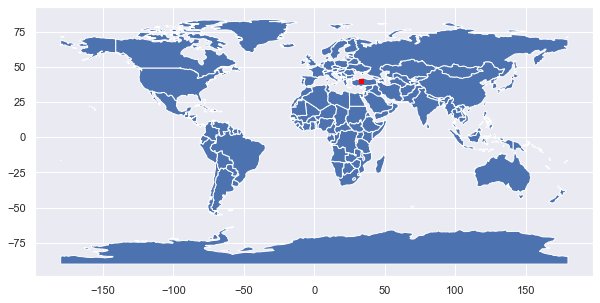

In [320]:
geometry = [Point(xy) for xy in zip(ds1['Longitude'], ds1['Latitude'])]
gdf = GeoDataFrame(ds1, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

# our location seems in Turkey, Ankara.

In [431]:
m = folium.Map([39.941000, 33.056167], zoom_start=11)


# mark each station as a point
for index, row in ds1.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']],
                        radius=15,
                        popup=row['SPID'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)


Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.
for our total wastewe cannot see generally these kind of helpfull results.

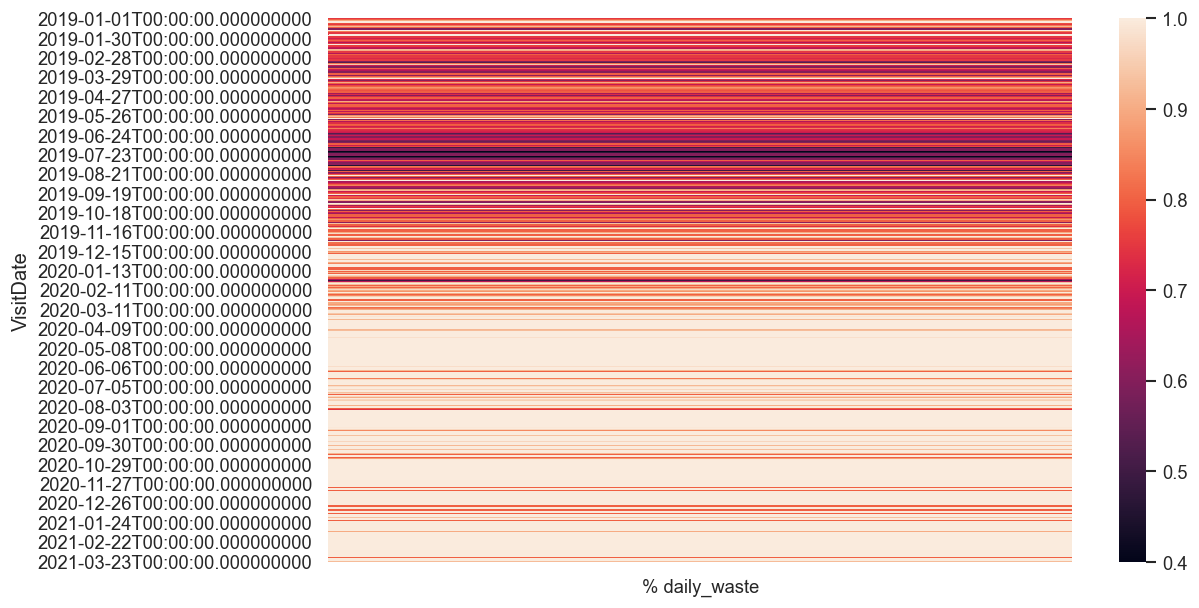

In [425]:
sns.heatmap(ts1)
plt.show()

#daily waste seems decreasing by time.

Decomposition of a Time Series
Lets look at multiplative and additive decompisotion for daily total waste percentage for each spid id


from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
for i in ts['SPID'].unique():
    subset = ts[ts['SPID'] == i]
    decompose_result_mult = seasonal_decompose(subset['% total_waste'], model="multiplicative")
    trend = decompose_result_mult.trend
    seasonal = decompose_result_mult.seasonal
    residual = decompose_result_mult.resid

    decompose_result_mult.plot();           ## seaonal effect

for i in ts['SPID'].unique():
    subset = ts[ts['SPID'] == i]
    decompose_result_mult = seasonal_decompose(subset['% total_waste'], model="additive")
    trend = decompose_result_mult.trend
    seasonal = decompose_result_mult.seasonal
    residual = decompose_result_mult.resid

    decompose_result_mult.plot();

they seem similar but ideally, multiplicative decomposition should be preferred for this particular series.

We’ll be using the rolling statistics plots along with Dickey-Fuller test results a lot so I have defined a function which takes a TS as input and generated them for us. Please note that I’ve plotted standard deviation instead of variance to keep the unit similar to mean.

In [251]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    #plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()
    
    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)


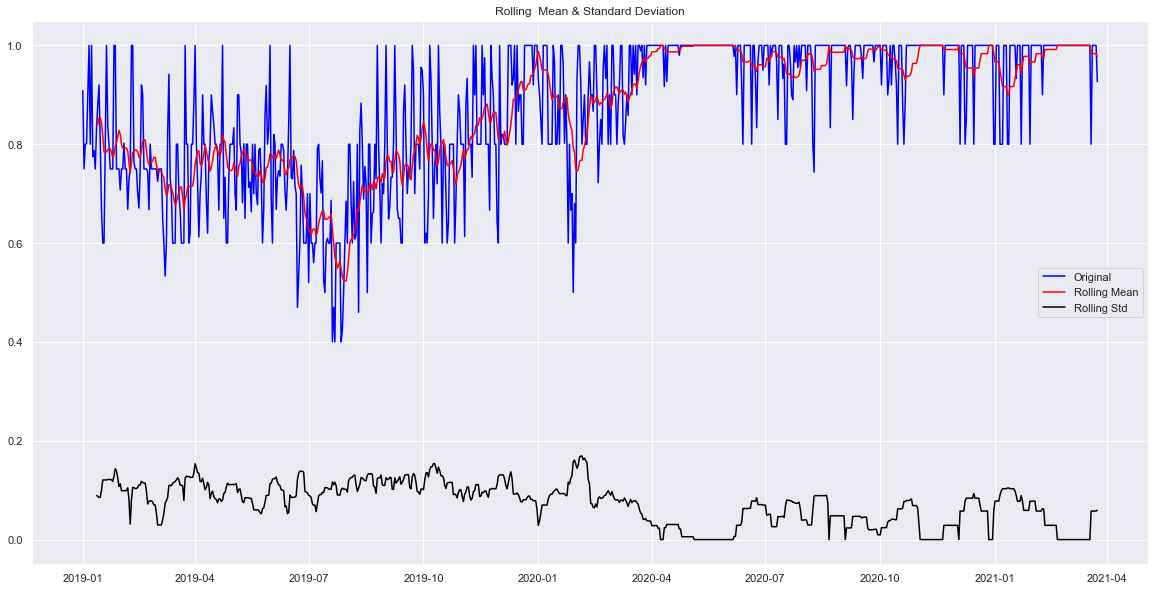

Results of Dickey-Fuller Test:
Test Statistic                  -1.294565
p-value                          0.631655
#Lags Used                      20.000000
Number of Observations Used    793.000000
Critical Value (1%)             -3.438623
Critical Value (5%)             -2.865192
Critical Value (10%)            -2.568714
dtype: float64


In [252]:
ts1 = ts1.set_index('VisitDate')
test_stationarity(ts1['% daily_waste'])
#p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
#Standard deviation has very less variation but mean is increasing continously. Hence, it's not a stationary series

Standard deviation has very less variation but mean is increasing continously. Hence, it's not a stationary series. Also, the test statistic is way more than the critical values (compare signed values and not the absolute values).

Make the Series Stationary:
Its almost impossible to make a series perfectly stationary, but we try to take it as close as possible.
The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

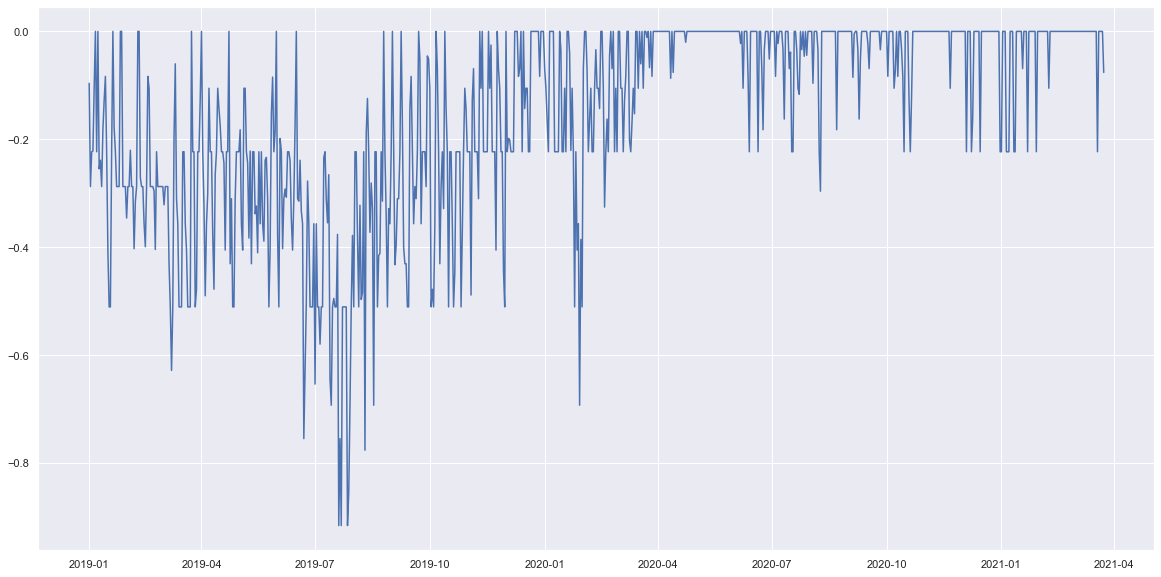

In [254]:
#Make the Series Stationary
#Estimating & Eliminating Trend
#let's take a log transform for simplicity:
ts_log = np.log(ts1)
plt.plot(ts_log)

Our time series is not stationary so we can use some techniques to estimate or model this trend and then remove it from the series. We use Smoothing – taking rolling averages for this time.

Mean Avarage:
In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.

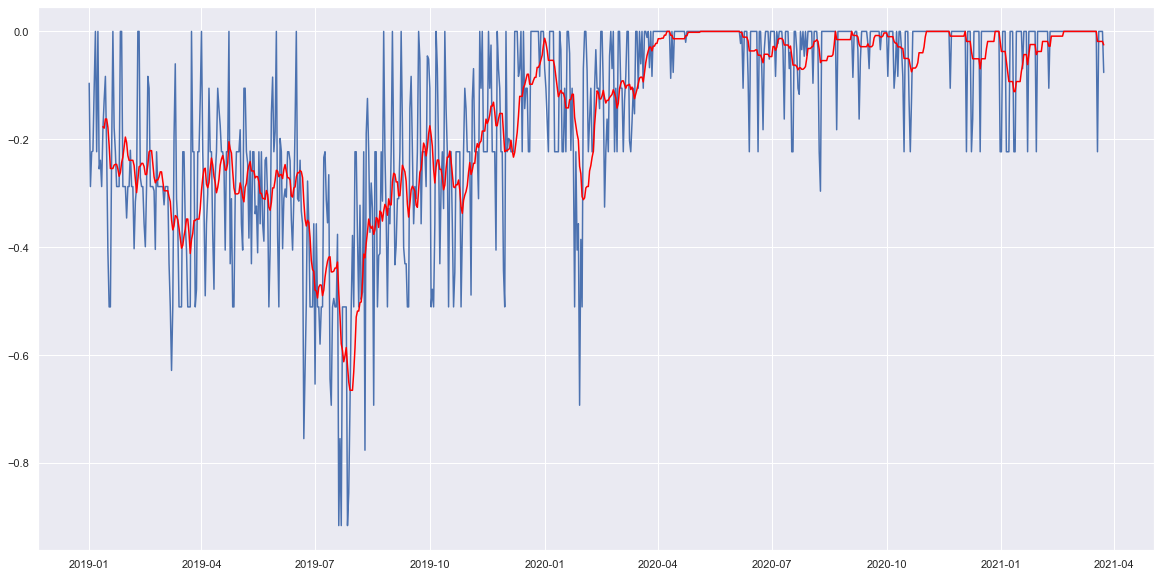

In [255]:
#moving avarage
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color = 'red')

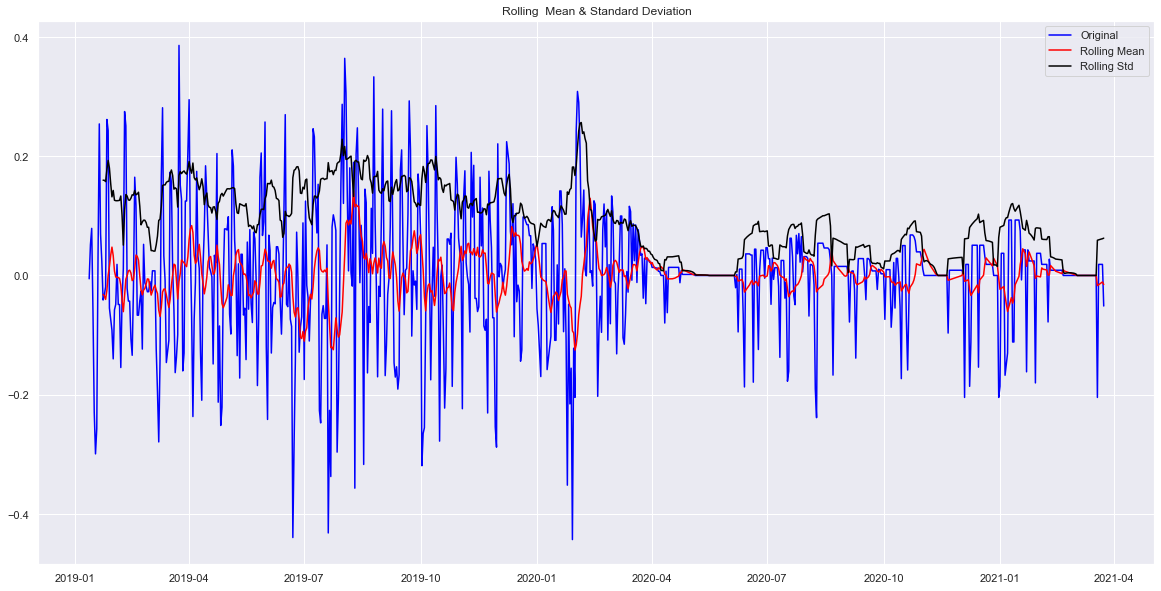

Results of Dickey-Fuller Test:
Test Statistic                -6.728055e+00
p-value                        3.350320e-09
#Lags Used                     2.000000e+01
Number of Observations Used    7.820000e+02
Critical Value (1%)           -3.438740e+00
Critical Value (5%)           -2.865243e+00
Critical Value (10%)          -2.568742e+00
dtype: float64


In [256]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(ts_log_moving_avg_diff)

the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series. However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a total waste, its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.



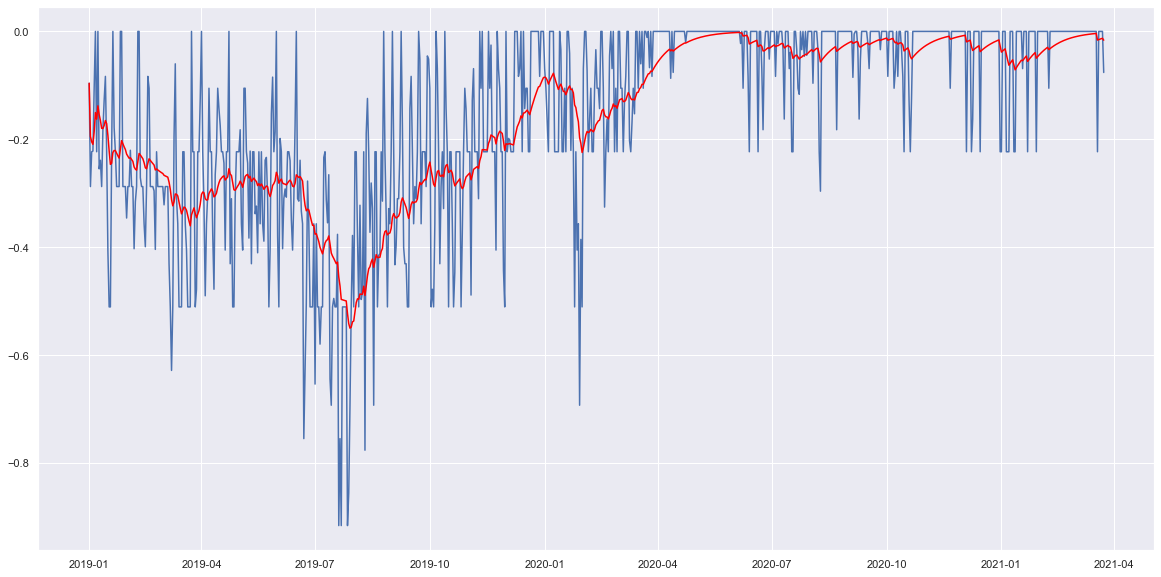

In [257]:
exp_weighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log)
plt.plot(exp_weighted_avg, color = 'red')

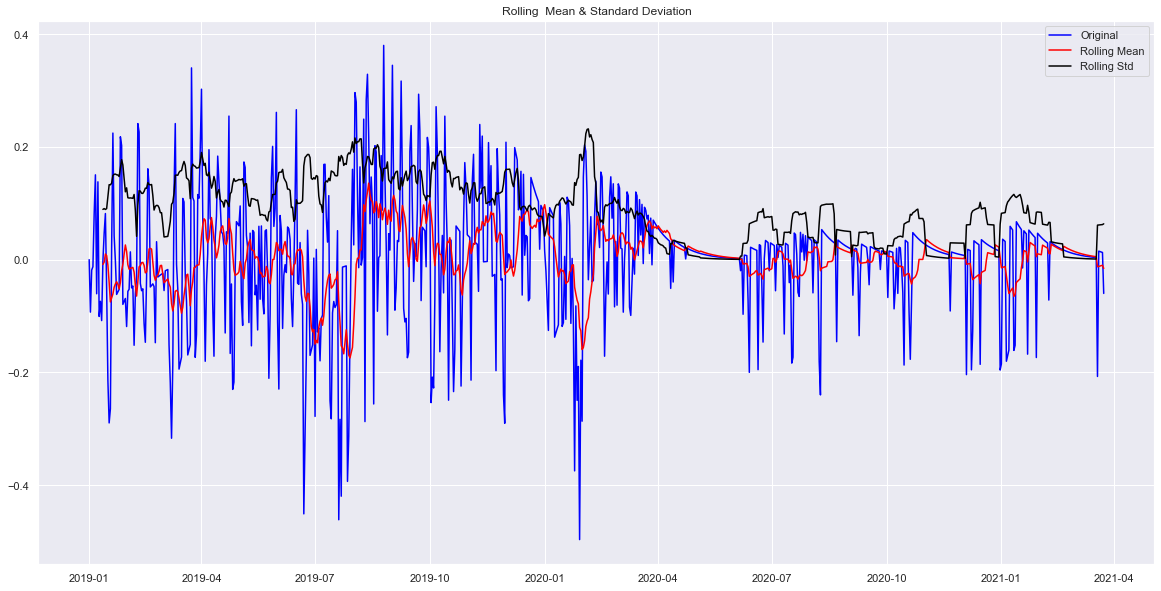

Results of Dickey-Fuller Test:
Test Statistic                  -4.607106
p-value                          0.000125
#Lags Used                      20.000000
Number of Observations Used    793.000000
Critical Value (1%)             -3.438623
Critical Value (5%)             -2.865192
Critical Value (10%)            -2.568714
dtype: float64


In [258]:
ts_log_ema_diff = ts_log - exp_weighted_avg
test_stationarity(ts_log_ema_diff)


the test statistic is smaller than the 1% critical value, which is better than the previous case.

Eliminating Trend and Seasonality:
Two methods:

Differencing (taking the differece with a particular time lag)
Decomposition (modeling both trend and seasonality and removing them from the model)


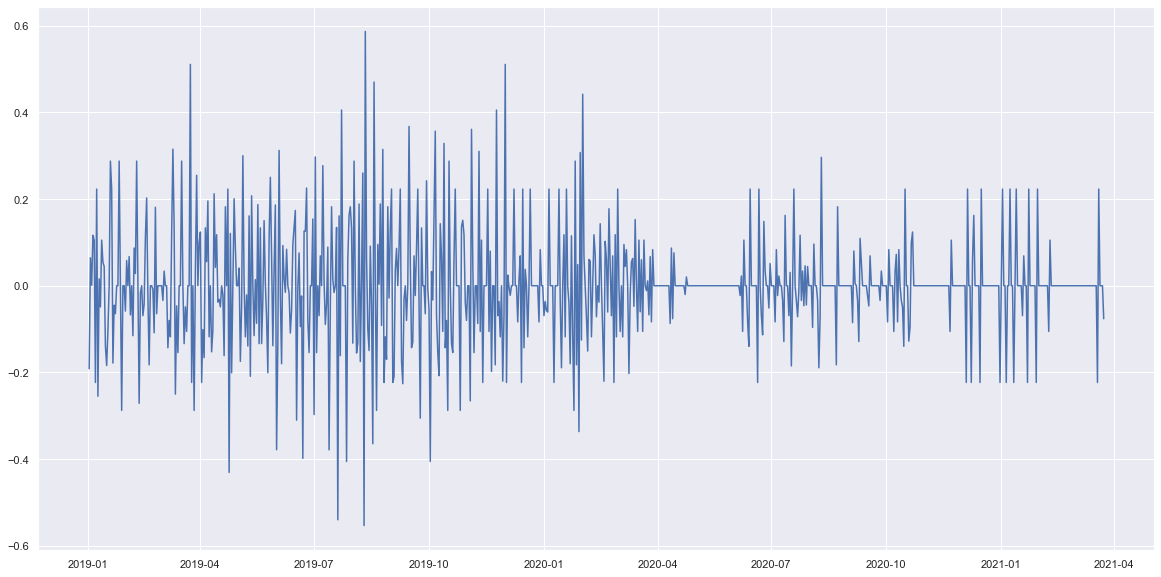

In [259]:
#eliminating tred and seasinality
#differenting:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
#ts_log.diff().plot()

The Dickey-Fuller test statistic is not significantly lower than the 1% critical value. So this TS is not very close to stationary.

### Forecasting a Time Series


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

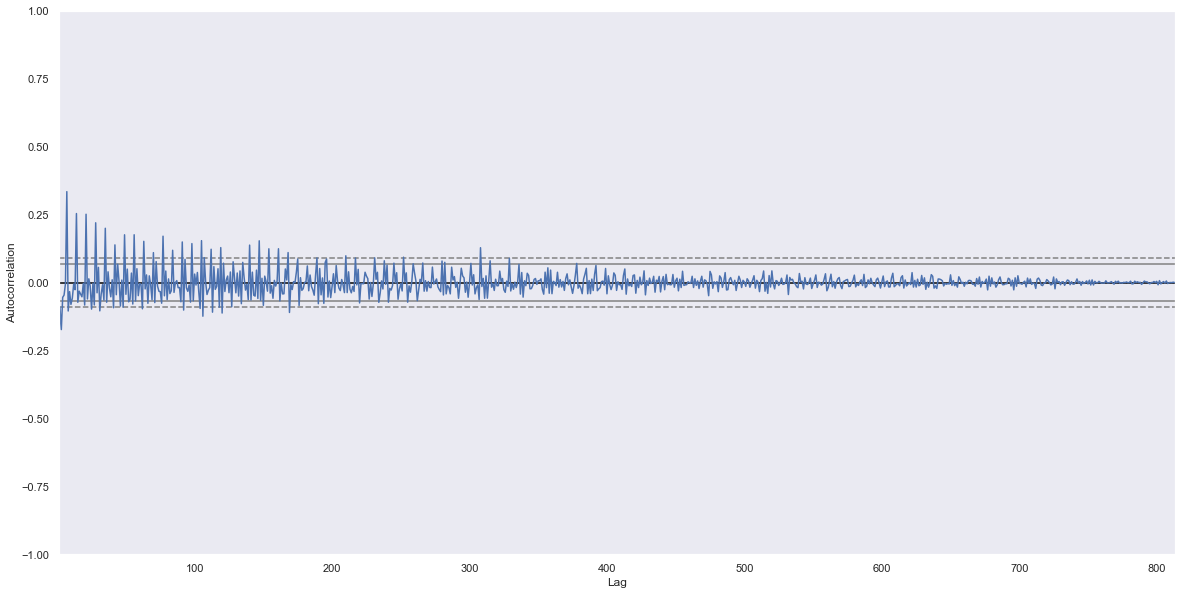

In [263]:
#forecasting
#ACF plot
pd.plotting.autocorrelation_plot(ts_log_diff)


Due to seasonality, at lag 10 autocorrelation is high and for every multiple of 12, autocorrelation will be high but will keep decreasing moving further.

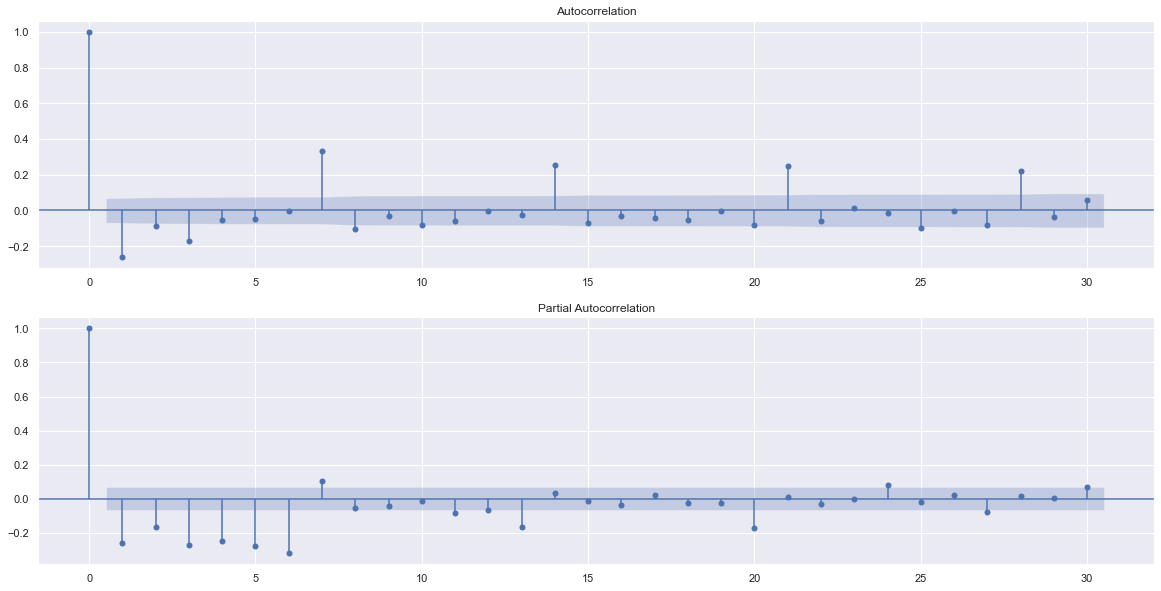

In [264]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.subplot(211)
plot_acf(ts_log_diff, ax=plt.gca())
plt.subplot(212)
plot_pacf(ts_log_diff, ax=plt.gca())
plt.show()


In [265]:
#Another method
#ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

/Users/gulsumbudakoglu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


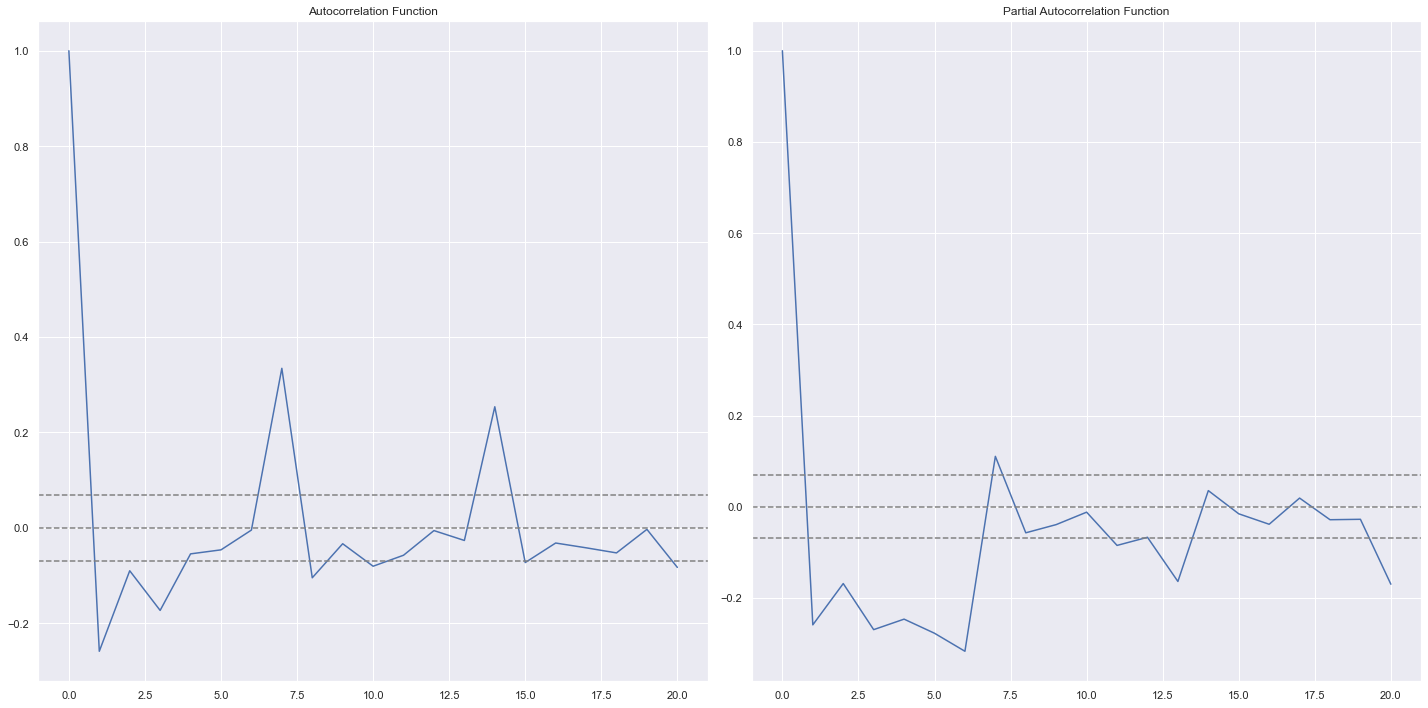

In [266]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray') #Add a horizontal line across the axis at y = 0.
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout() #Automatically adjust subplot parameters to give specified padding.

Now, lets make 3 different ARIMA models considering individual as well as combined effects. We will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.

We need to load the ARIMA model first:

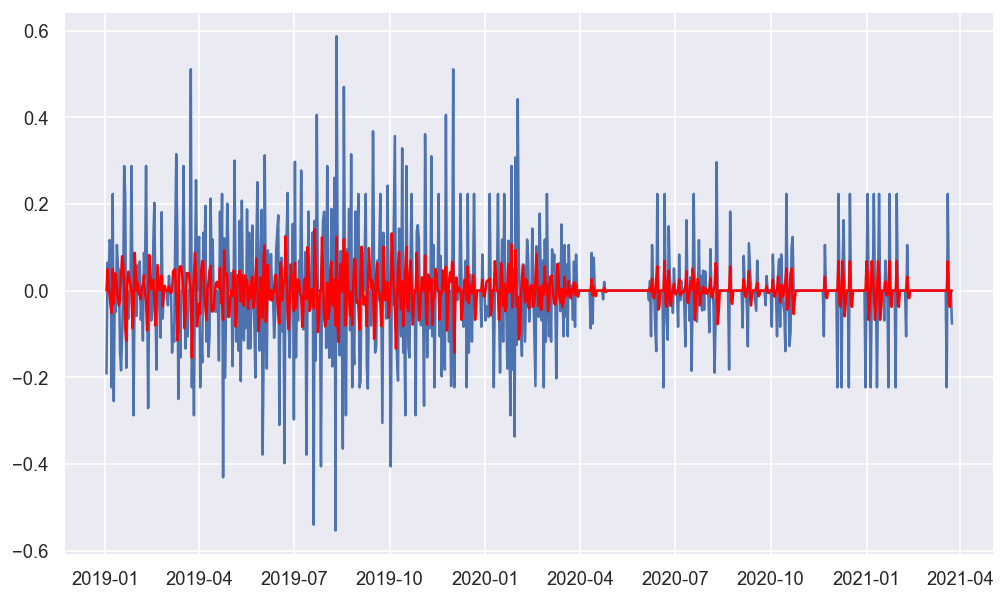

In [381]:
from statsmodels.tsa.arima_model import ARIMA, ARMAResults

#AR model
model = ARIMA(ts_log, order = (2,1,0))
results_AR = model.fit(disp = -1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color = 'red') 
#plt.title('RSS: %.4f'% np.sum((results_AR.fittedvalues - ts_log_diff)**2)) #Residual sum of squares

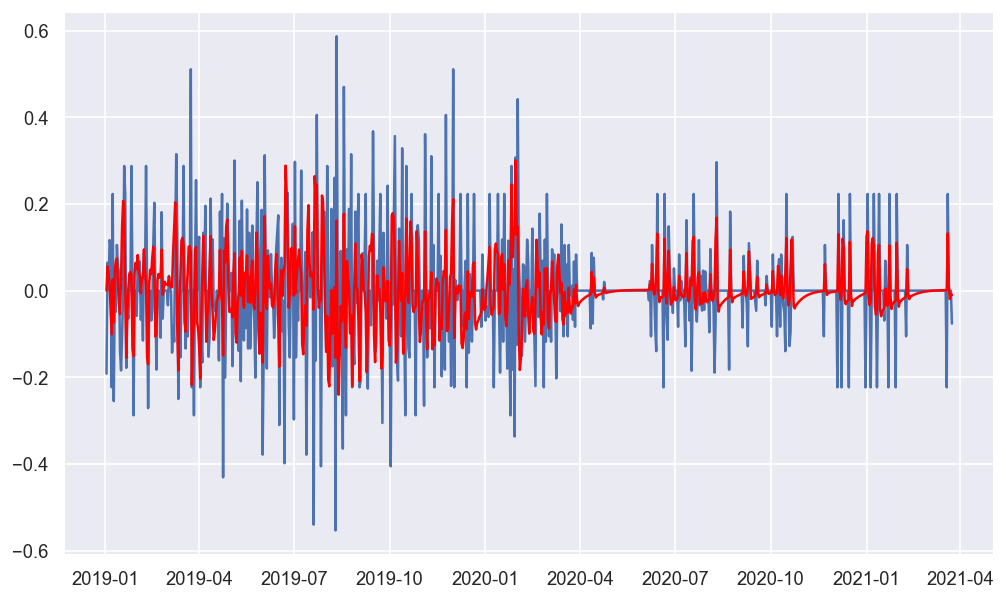

In [382]:
#ma model
model = ARIMA(ts_log, order= (0, 1, 2))  
results_MA = model.fit(disp = -1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color= 'red')
#plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - ts_log_diff)**2))

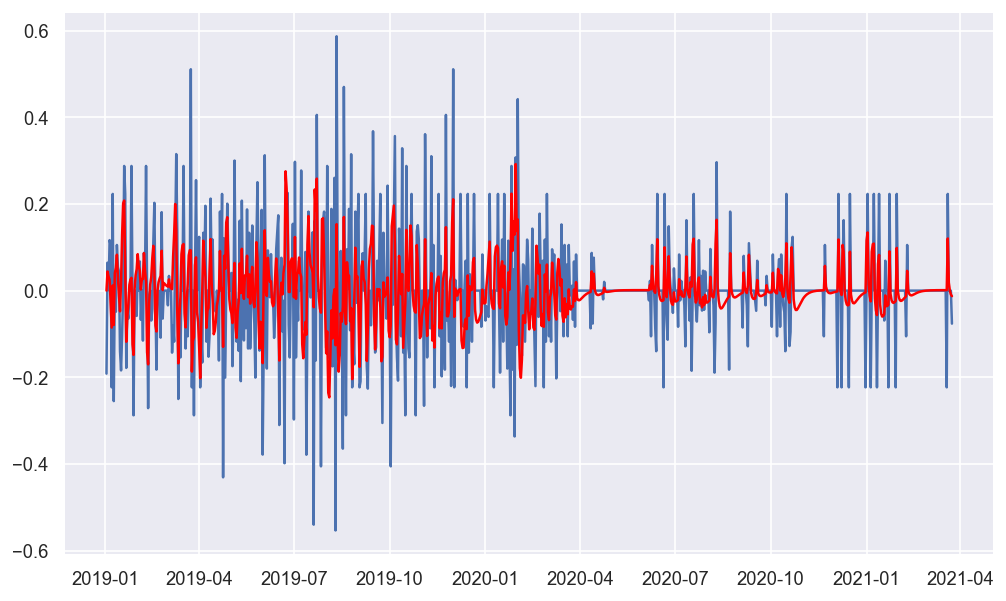

In [383]:
#combined model:
model = ARIMA(ts_log, order = (2, 1, 2))  
results_ARIMA = model.fit(disp = -1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color= 'red')
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - ts_log_diff)**2))

Here we can see that the AR and MA models have almost the same RSS but combined is better.

In [270]:
#taking back to origin scale
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

VisitDate
2019-01-02    0.000179
2019-01-03    0.044086
2019-01-04    0.032379
2019-01-05    0.025267
2019-01-06   -0.027456
dtype: float64

In [271]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

VisitDate
2019-01-02    0.000179
2019-01-03    0.044265
2019-01-04    0.076644
2019-01-05    0.101912
2019-01-06    0.074455
dtype: float64

In [272]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

VisitDate
2019-01-01         NaN
2019-01-02    0.000179
2019-01-03    0.044265
2019-01-04    0.076644
2019-01-05    0.101912
dtype: float64

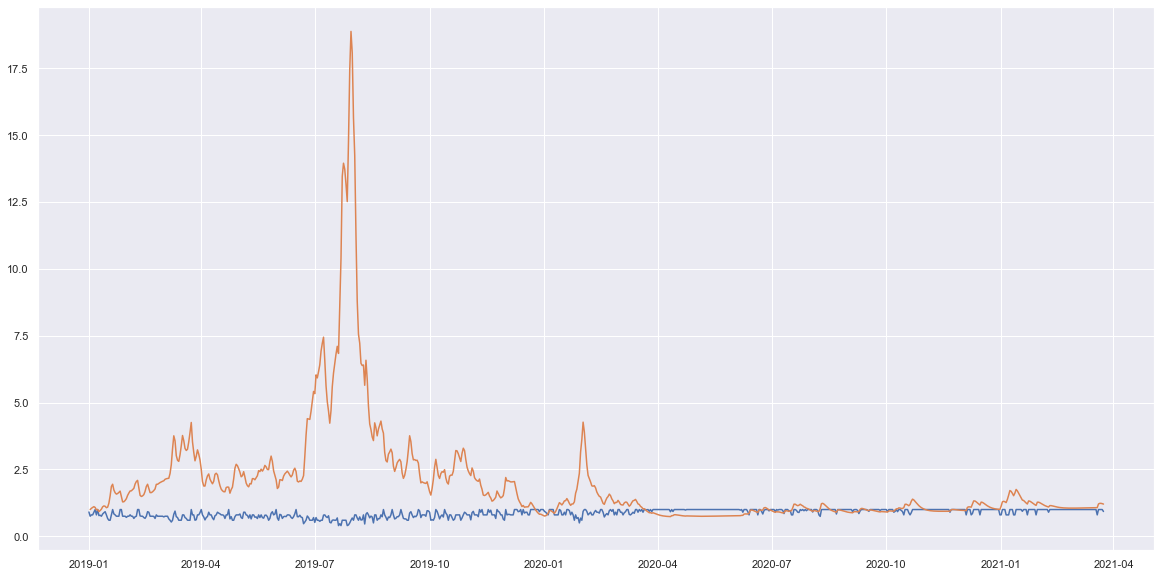

In [279]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts1)
plt.plot(predictions_ARIMA)
#plt.title('RMSE: %.4f'% np.sqrt(sum(((predictions_ARIMA)-ts1)**2)/len(ts1)))


This predicton is not that much good as it should be and root mean square error is also very high.
Using SARIMAX:

In [280]:
#Another method (using SARIMAX)
#1. Parameter Selection for the ARIMA Time Series Model

import itertools
p = d = q = range(2)
pdq = list(itertools.product(p, d, q))      #Generate all different combinations of p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]       #Generate all different combinations of seasonal p, q and q triplet


In [281]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")           #Specify to ignore warning messages
AIC_df = pd.DataFrame({}, columns = ['param', 'param_seasonal', 'AIC'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_log, order = param, seasonal_order = param_seasonal, enforce_stationarity = False, enforce_invertibility = False)
            results = mod.fit()
            #print('ARIMA{}x{}-AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[param, param_seasonal, results.aic]], columns = ['param', 'param_seasonal', 'AIC'])
            AIC_df = AIC_df.append(temp, ignore_index = True)
            del temp
        except:
            continue


In [282]:
#Fitting an ARIMA Time Series Model

min_aic = AIC_df.sort_values(by = 'AIC').iloc[0]    #Row with minimum AIC value
model = sm.tsa.statespace.SARIMAX(ts_log, order = min_aic.param, seasonal_order = min_aic.param_seasonal, enforce_stationarity = False, enforce_invertibility = False)
results = model.fit()
#print(results.summary())
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3602      0.030     12.193      0.000       0.302       0.418
ma.L1         -0.9294      0.012    -80.581      0.000      -0.952      -0.907
sigma2         0.0118      0.000     29.804      0.000       0.011       0.013


The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower to 0.05, so it is reasonable to retain all of them in our model.

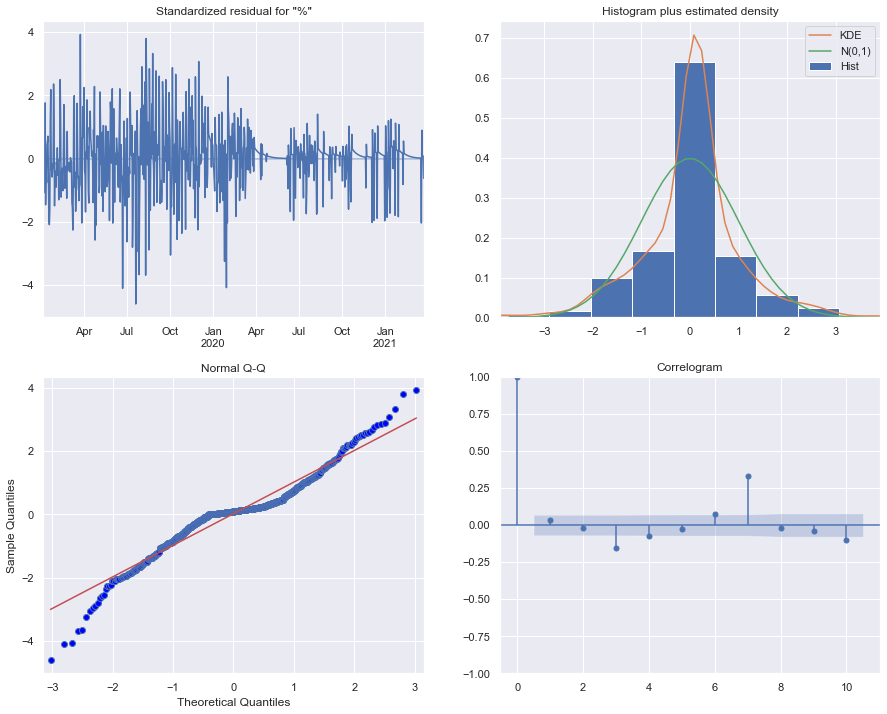

In [283]:
results.plot_diagnostics(figsize=(15, 12))    #Generate model diagnostics and investigate for any unusual behavior.
plt.show()

1.In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed. 2.The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed. 3.The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

In [356]:
#Validating forecast:

#Obtain values for forecasts of the time series from 1958
pred = results.get_prediction(start = pd.to_datetime('2021-01-01'), dynamic = False)
#Obtain associated confidence intervals for forecasts of the time series
pred_ci = pred.conf_int()
pred_ci.head()

,lower % daily_waste,upper % daily_waste
2021-01-01,-0.317288,0.109122
2021-01-02,-0.325690,0.100721
2021-01-03,-0.237377,0.189033
2021-01-04,-0.235671,0.190739
2021-01-05,-0.234086,0.192324


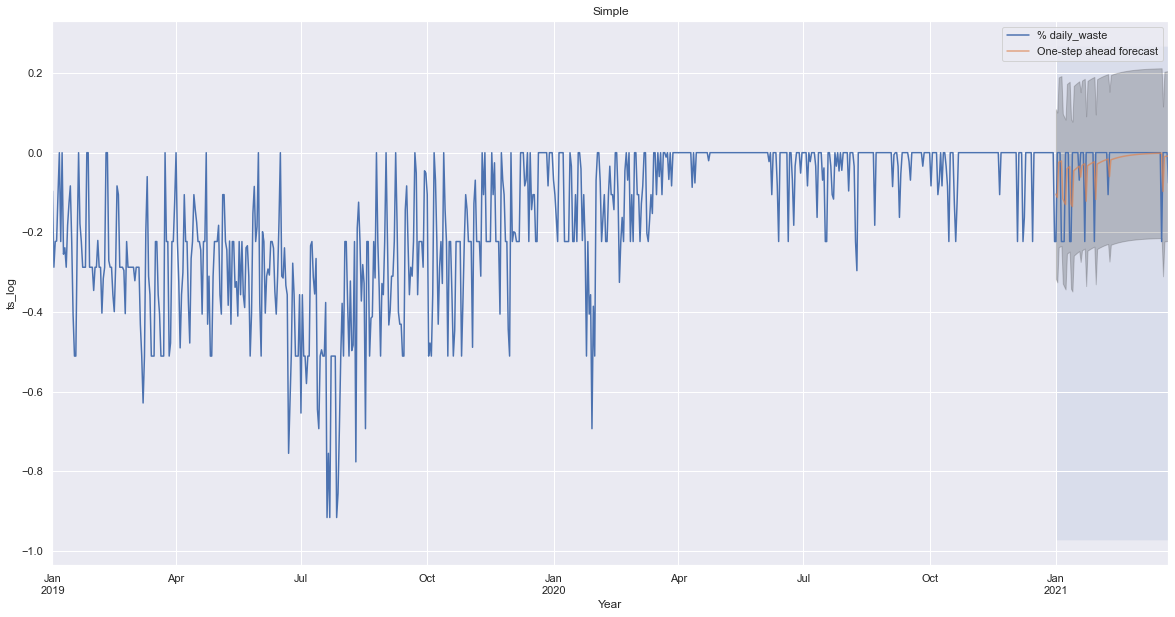

In [357]:
#Plot the forecasted values with historical data
ax = ts_log['2014':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'One-step ahead forecast', alpha = 0.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = .2)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-01-01'), ts_log.index[-1], alpha = .1, zorder = -1)
plt.xlabel('Year')
plt.ylabel('ts_log')
plt.title('Simple')
plt.legend()

In [358]:
pred.predicted_mean.head()

2021-01-01   -0.104083
2021-01-02   -0.112485
2021-01-03   -0.024172
2021-01-04   -0.022466
2021-01-05   -0.020881
Freq: D, Name: predicted_mean, dtype: float64

In [359]:
from sklearn.metrics import mean_squared_error
ts_log_forecasted = pred.predicted_mean     
ts_log_original = ts_log['2021-01-01':]
#mse = ((ts_log_forecasted - ts_log_original) ** 2).mean() 
mse= mean_squared_error(ts_log_forecasted , ts_log_original)#Mean square error
print('Mean Squared Error of forecast : {}'.format(round(mse,3)))

Mean Squared Error of forecast : 0.005


In [360]:
pred_uc = results.get_forecast(steps=100)     #Get forecast 100 steps ahead in future (ts_log)
pred_ci = pred_uc.conf_int()                  #Get confidence intervals of forecasts (ts_log)
pred_ci.head()

,lower % daily_waste,upper % daily_waste
2021-03-25,-0.253476,0.172934
2021-03-26,-0.259488,0.204801
2021-03-27,-0.259767,0.214393
2021-03-28,-0.260291,0.218271
2021-03-29,-0.261173,0.220361


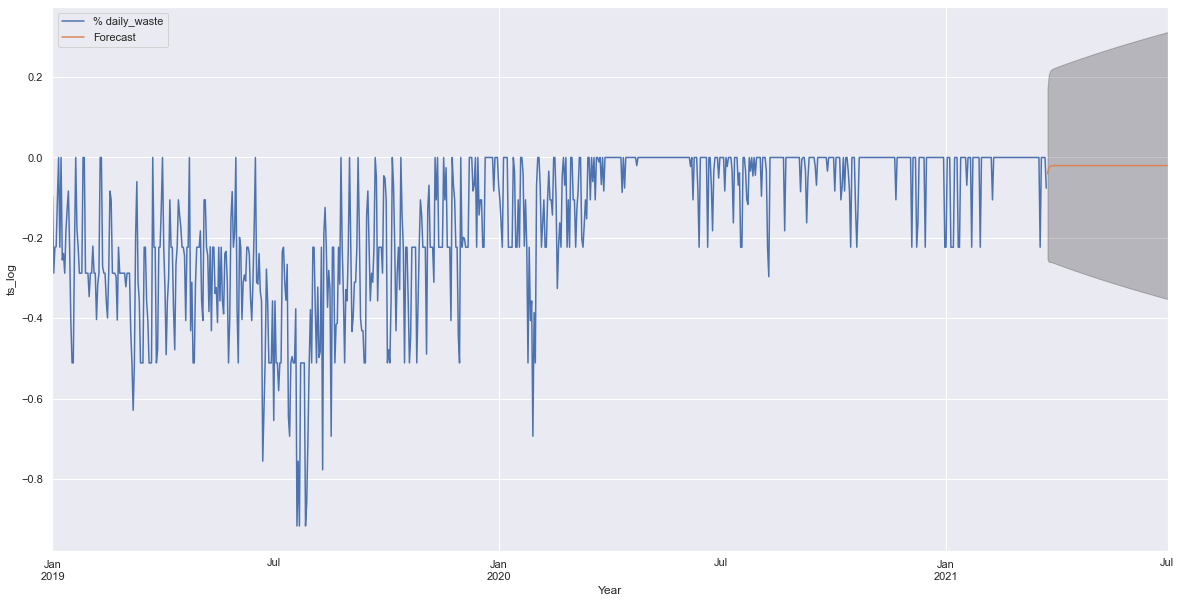

In [361]:
ax = ts_log['2014':].plot(label='Observed')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('ts_log')
plt.legend(loc = 'upper left')
plt.show()

In [362]:
#Take exponential function
pred_uc = np.exp(pred_uc.predicted_mean)
pred_ci = np.exp(pred_ci)

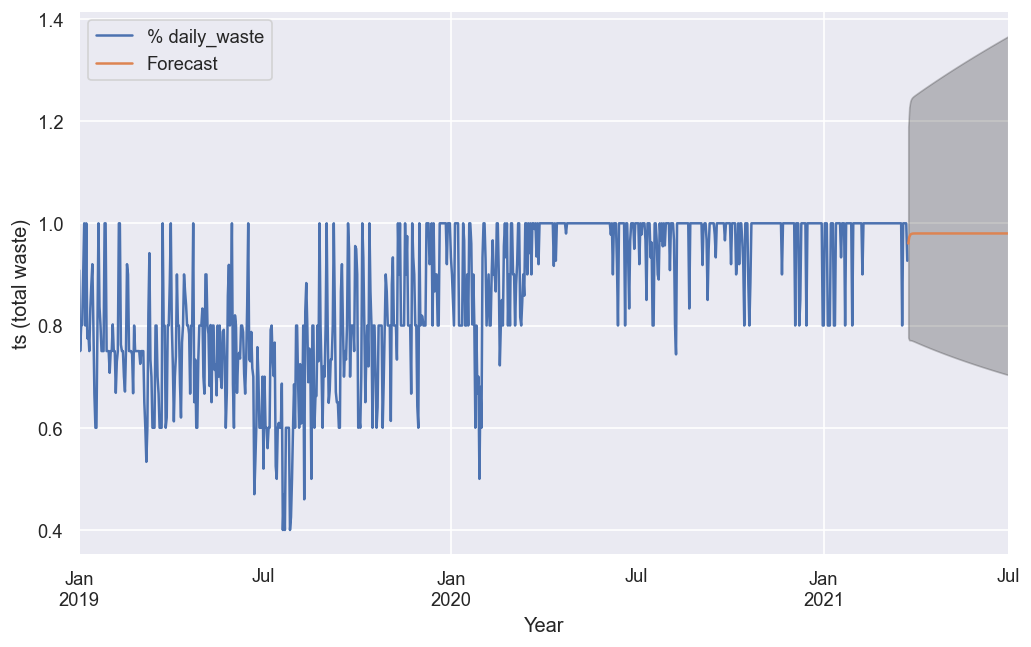

In [384]:
#Plot original data prediction
ax = ts1['2014':].plot(label='Observed')
pred_uc.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('ts (total waste)')
plt.legend(loc = 'upper left')
plt.show()

the one-step ahead confirms that this time series model is valid. It has 0.005 mss. However, much of the interest around time series forecasting is the ability to forecast future values way ahead in time and our model cannot do it now maybe because of our informations is not enough. there are most decreasig points in jul 2019.